In [ ]:
# Teacher Discourse Analysis: In-Service vs Pre-Service Teachers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import spacy
from sentence_transformers import SentenceTransformer

# --- 1. Load Your Corpus ---

# Replace 'your_corpus.csv' with your real file
# df = pd.read_csv('your_corpus.csv')

# For now I'll simulate a small sample structure:
df = pd.read_csv('data/corpus_data_combined.csv')  # Adjust path if needed

print("Corpus loaded with shape:", df.shape)
df[['text', 'pre_or_in_service']].head()

# --- 2. Preprocessing (French Tokenization, Lemmatization) ---

nlp = spacy.load('fr_core_news_md')

def preprocess(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_space]
    return " ".join(tokens)

print("Preprocessing texts...")
df['clean_text'] = df['text'].apply(preprocess)

# --- 3. Create Embeddings (Sentence-Transformer) ---

model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

print("Creating embeddings...")
embeddings = model.encode(df['clean_text'].tolist(), show_progress_bar=True)

/Users/tijuana/miniconda3/envs/p311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Corpus loaded with shape: (8751, 38)
Preprocessing texts...


In [ ]:
# --- 4. Dimensionality Reduction (PCA and UMAP) ---
import umap.umap_ as umap
print("Running PCA and UMAP...")
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

umap_result = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine').fit_transform(embeddings)


Running PCA and UMAP...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


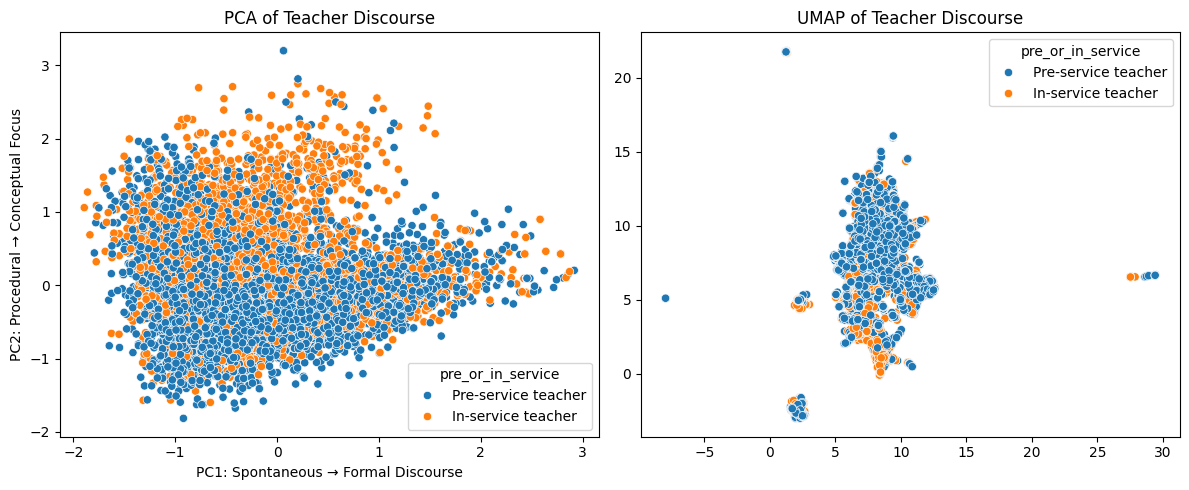

Running KMeans clustering...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


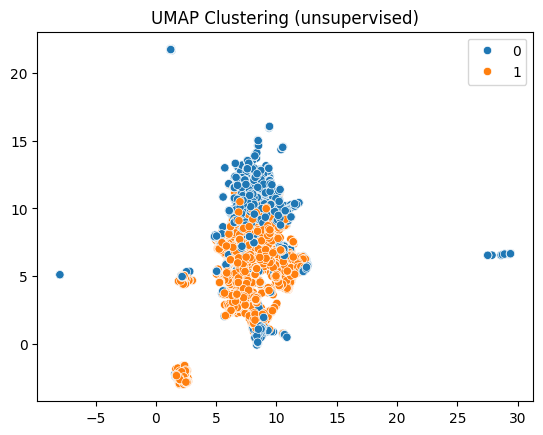

Training classifier...
                     precision    recall  f1-score   support

 In-service teacher       0.69      0.45      0.54       680
Pre-service teacher       0.71      0.87      0.79      1071

           accuracy                           0.71      1751
          macro avg       0.70      0.66      0.66      1751
       weighted avg       0.71      0.71      0.69      1751

Top words for In-Service Teachers:
[('le', 4666), ('être', 3116), ('de', 2726), ('vous', 2533), ('ce', 2483), ('avoir', 2465), ('que', 2060), ('un', 1993), ('cela', 1555), ('on', 1524), ('faire', 1454), ('il', 1254), ('pouvoir', 1210), ('je', 1154), ('tu', 1070), ('et', 1050), ('à', 1044), ('pas', 920), ('aller', 918), ('nom_d_un_e_élève', 868)]
Top words for Pre-Service Teachers:
[('le', 5749), ('être', 4197), ('ce', 3521), ('de', 3127), ('avoir', 2852), ('que', 2775), ('vous', 2508), ('on', 2414), ('un', 2132), ('tu', 1988), ('faire', 1918), ('cela', 1912), ('aller', 1599), ('il', 1572), ('pouvoir',

In [ ]:
# --- 5. Visualization (Scatterplots) ---

plt.figure(figsize=(12,5))

# PCA Scatter
plt.subplot(1,2,1)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=df['pre_or_in_service'])
plt.xlabel('PC1: Spontaneous → Formal Discourse')
plt.ylabel('PC2: Procedural → Conceptual Focus')
plt.title('PCA of Teacher Discourse')

# UMAP Scatter
plt.subplot(1,2,2)
sns.scatterplot(x=umap_result[:,0], y=umap_result[:,1], hue=df['pre_or_in_service'])
plt.title('UMAP of Teacher Discourse')  # no x/y label because UMAP axes aren't meaningful

plt.tight_layout()
plt.show()

# --- 6. Cluster Analysis ---

print("Running KMeans clustering...")
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(embeddings)

sns.scatterplot(x=umap_result[:,0], y=umap_result[:,1], hue=kmeans_labels, palette='tab10')
plt.title('UMAP Clustering (unsupervised)')
plt.show()

# --- 7. Classification (In-Service vs Pre-Service) ---

print("Training classifier...")
X_train, X_test, y_train, y_test = train_test_split(embeddings, df['pre_or_in_service'], test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

# --- 8. Bonus: Word Frequency Analysis ---

from collections import Counter

def get_top_words(series, n=20):
    all_words = " ".join(series).split()
    freq = Counter(all_words)
    return freq.most_common(n)

print("Top words for In-Service Teachers:")
print(get_top_words(df[df['pre_or_in_service'] == 'In-service teacher']['clean_text']))

print("Top words for Pre-Service Teachers:")
print(get_top_words(df[df['pre_or_in_service'] == 'Pre-service teacher']['clean_text']))


In [ ]:
# Build a DataFrame to compare
kmeans_df = pd.DataFrame({
    'kmeans_cluster': kmeans_labels,
    'real_label': df['pre_or_in_service']
})

# See how clusters match real labels
print(pd.crosstab(kmeans_df['kmeans_cluster'], kmeans_df['real_label']))


real_label      In-service teacher  Pre-service teacher
kmeans_cluster                                         
0                             1221                 2385
1                             2109                 3036


In [ ]:
# Look at the explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Look at the PCA components
print("PCA components shape:", pca.components_.shape)

# For interpretation, let's visualize the loadings
loading_matrix = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'])

# Optional: Look at the top contributing dimensions
top_PC1 = loading_matrix['PC1'].abs().sort_values(ascending=False).head(10)
top_PC2 = loading_matrix['PC2'].abs().sort_values(ascending=False).head(10)

print("Top dimensions influencing PC1:\n", top_PC1)
print("Top dimensions influencing PC2:\n", top_PC2)


Explained variance ratio: [0.10568073 0.06408482]
PCA components shape: (2, 384)
Top dimensions influencing PC1:
 99     0.407271
224    0.168220
62     0.166133
141    0.144850
11     0.141042
380    0.138326
347    0.134757
204    0.127412
6      0.119857
262    0.118698
Name: PC1, dtype: float32
Top dimensions influencing PC2:
 32     0.157946
197    0.154683
288    0.139049
254    0.133633
73     0.130532
99     0.130168
156    0.130004
244    0.122580
263    0.121697
60     0.121379
Name: PC2, dtype: float32


In [ ]:
# 1. Attach PCA coordinates
df['PC1'] = pca_result[:,0]
df['PC2'] = pca_result[:,1]

# 2. Define threshold for extreme cases
top_n = 50  # Number of extreme teachers to consider

# 3. Get top and bottom groups for PC1
high_PC1_texts = df.sort_values('PC1', ascending=False).head(top_n)['clean_text']
low_PC1_texts = df.sort_values('PC1', ascending=True).head(top_n)['clean_text']

# 4. Get top and bottom groups for PC2
high_PC2_texts = df.sort_values('PC2', ascending=False).head(top_n)['clean_text']
low_PC2_texts = df.sort_values('PC2', ascending=True).head(top_n)['clean_text']

# 5. Word frequency analysis
def get_frequent_words(texts, n=100):
    words = " ".join(texts).split()
    freq = Counter(words)
    return freq.most_common(n)

print("\nWords most frequent for HIGH PC1:")
print(get_frequent_words(high_PC1_texts))

print("\nWords most frequent for Low PC1:")
print(get_frequent_words(low_PC1_texts))


print("\nWords most frequent for HIGH PC2:")
print(get_frequent_words(high_PC2_texts))
print("\nWords most frequent for Low PC2:")
print(get_frequent_words(low_PC2_texts))


NameError: name 'pca_result' is not defined

PC1 (10.5% of variance) reflects a contrast between highly spontaneous, conversational teacher discourse and more formal, structured instructional discourse. Teachers on the positive side frequently use interjections and emotional reactions (e.g., ouai, ah, hm), whereas those on the negative side employ a higher frequency of articles, verbs, and content delivery language.

PC2 (6.4% of variance) captures a shift between abstract conceptual discussions (e.g., about programming, language, and commands) and highly concrete procedural instructions (e.g., movement directions, degrees, turtle control), with teachers at the negative end focusing more on guiding precise physical actions.

In [ ]:
from transformers import pipeline


# --- 7. Classification (In-Service vs Pre-Service) ---

print("Training classifier...")
X_train, X_test, y_train, y_test = train_test_split(embeddings, df['pre_or_in_service'], test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

Training classifier...
                     precision    recall  f1-score   support

 In-service teacher       0.69      0.45      0.54       680
Pre-service teacher       0.71      0.87      0.79      1071

           accuracy                           0.71      1751
          macro avg       0.70      0.66      0.66      1751
       weighted avg       0.71      0.71      0.69      1751



Running sentiment analysis (multilingual model)...


Device set to use mps:0


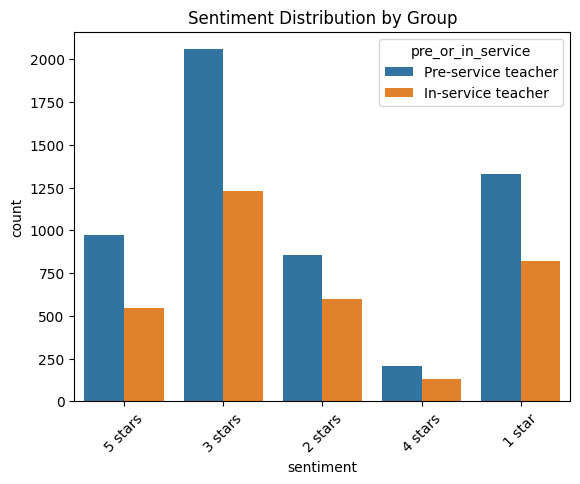

In [ ]:
# --- 8. Sentiment Analysis (French-compatible) ---
print("Running sentiment analysis (multilingual model)...")
sentiment_model = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")
df['sentiment'] = df['text'].astype(str).apply(lambda x: sentiment_model(x[:512])[0]['label'])  # Truncate long texts

sns.countplot(data=df, x='sentiment', hue='pre_or_in_service')
plt.title("Sentiment Distribution by Group")
plt.xticks(rotation=45)
plt.show()


Sentiment analysis shows that pre-service teachers’ discourse is more emotionally varied, with a higher proportion of both highly positive (5-star) and highly negative (1-star) utterances. In contrast, in-service teachers’ speech tends to be more stable, showing fewer extreme sentiments. This suggests that experienced teachers may adopt a more emotionally neutral or professionally detached tone in their discourse compared to novices.

In [ ]:
# Step 1: Convert 'sentiment' labels like '4 stars' to numeric values
df['stars'] = df['sentiment'].str.extract(r'(\d)').astype(int)

# Step 2: Map numeric stars to sentiment categories
def map_star_to_sentiment(star):
    if star >= 4:
        return 'positive'
    elif star == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment_group'] = df['stars'].apply(map_star_to_sentiment)


In [ ]:
# Step 2: Proper reset

# Step 3: Melt for long format


# Step 4: Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=summary,
    x='sentiment_group',
    y='proportion',
    hue='pre_or_in_service'
)

# Optional: add percentage labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', label_type='edge', padding=3)

plt.title("Normalized Sentiment Distribution by Group (based on 5-Star Model Output)")
plt.ylabel("Proportion of Texts")
plt.xlabel("Sentiment Category")
plt.ylim(0, 1)
plt.legend(title="Teacher Group")
plt.tight_layout()
plt.show()


NameError: name 'summary' is not defined

<Figure size 800x500 with 0 Axes>

In [ ]:
from scipy.stats import chi2_contingency

# --- Prepare contingency table (counts, not proportions) ---
contingency_table = pd.crosstab(df['pre_or_in_service'], df['sentiment_group'])

print("Contingency Table:")
print(contingency_table)

# --- Run Chi-Square Test ---
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-Square Statistic = {chi2:.4f}")
print(f"p-value = {p:.6f}")
print(f"Degrees of Freedom = {dof}")


Contingency Table:
sentiment_group      Negative  Neutral  Positive
pre_or_in_service                               
In-service teacher       1422     1232       676
Pre-service teacher      2187     2057      1177

Chi-Square Statistic = 5.2193
p-value = 0.073560
Degrees of Freedom = 2


A Chi-Square Test of Independence was conducted to examine the relationship between teacher experience (pre-service vs in-service) and sentiment distribution. The test was not statistically significant, χ²(2) = 5.22, p = 0.074, suggesting that sentiment categories are similarly distributed across the two groups.

Extracting style features...


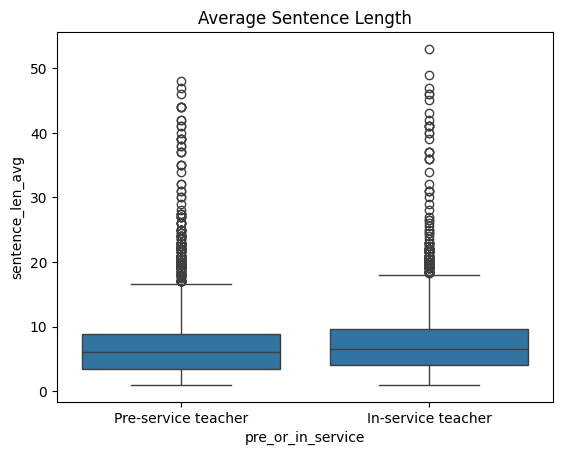

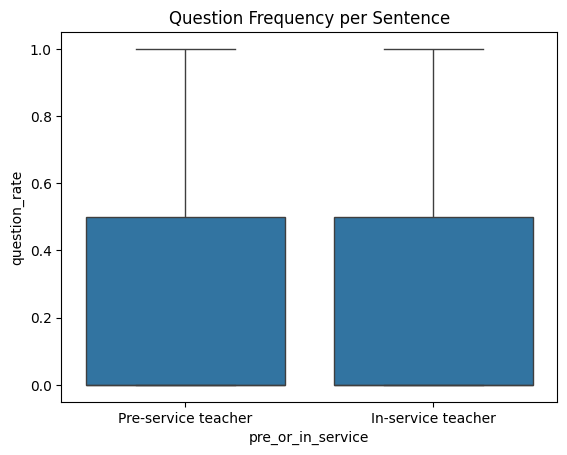

In [ ]:
# --- 9. Style Features (question rate, avg sentence length, pronouns) ---

def extract_style_features(text):
    doc = nlp(text)
    sentences = list(doc.sents)
    n_sentences = len(sentences)
    words = [token.text.lower() for token in doc if token.is_alpha]
    question_count = sum(1 for sent in sentences if '?' in sent.text)
    pronouns = [token.text.lower() for token in doc if token.pos_ == 'PRON']
    return pd.Series({
        'sentence_len_avg': np.mean([len(sent.text.split()) for sent in sentences]) if sentences else 0,
        'question_rate': question_count / n_sentences if n_sentences else 0,
        'pronoun_rate': len(pronouns) / len(words) if words else 0
    })

print("Extracting style features...")
style_feats = df['text'].astype(str).apply(extract_style_features)
df = pd.concat([df, style_feats], axis=1)

sns.boxplot(data=df, x='pre_or_in_service', y='sentence_len_avg')
plt.title("Average Sentence Length")
plt.show()

sns.boxplot(data=df, x='pre_or_in_service', y='question_rate')
plt.title("Question Frequency per Sentence")
plt.show()




In [ ]:
# --- 10. Top Words by Group ---

nlp = spacy.load('fr_core_news_md')

def preprocess(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_space]
    return " ".join(tokens)

print("Preprocessing texts...")
df['clean_text'] = df['text'].astype(str).apply(preprocess)


def get_top_words(series, n=20):
    # Drop NaN or empty texts
    series = series.dropna()
    series = series[series.str.strip() != '']
    if len(series) == 0:
        return []
    all_words = " ".join(series).split()
    freq = Counter(all_words)
    return freq.most_common(n)


print("Top words for In-Service Teachers:")
print(get_top_words(df[df['pre_or_in_service'] == 'In-service teacher']['clean_text']))

print("Top words for Pre-Service Teachers:")
print(get_top_words(df[df['pre_or_in_service'] == 'Pre-service teacher']['clean_text']))




Preprocessing texts...
Top words for In-Service Teachers:
[('le', 4666), ('être', 3116), ('de', 2726), ('vous', 2533), ('ce', 2483), ('avoir', 2465), ('que', 2060), ('un', 1993), ('cela', 1555), ('on', 1524), ('faire', 1454), ('il', 1254), ('pouvoir', 1210), ('je', 1154), ('tu', 1070), ('et', 1050), ('à', 1044), ('pas', 920), ('aller', 918), ('nom_d_un_e_élève', 868)]
Top words for Pre-Service Teachers:
[('le', 5749), ('être', 4197), ('ce', 3521), ('de', 3127), ('avoir', 2852), ('que', 2775), ('vous', 2508), ('on', 2414), ('un', 2132), ('tu', 1988), ('faire', 1918), ('cela', 1912), ('aller', 1599), ('il', 1572), ('pouvoir', 1418), ('pas', 1354), ('et', 1297), ('je', 1260), ('à', 1238), ('là', 1080)]


In [ ]:
print(df['pre_or_in_service'].unique())

['Pre-service teacher' 'In-service teacher']


In [ ]:
import plotly.express as px
# --- 11. Interactive UMAP Plot with Plotly ---

umap_df = pd.DataFrame(umap_result, columns=['UMAP_1', 'UMAP_2'])
umap_df['group'] = df['pre_or_in_service']
umap_df['sentiment'] = df['sentiment']

fig = px.scatter(umap_df, x='UMAP_1', y='UMAP_2', color='group', hover_data=['sentiment'])
fig.update_layout(title="UMAP of Teacher Discourse (colored by group)")
fig.show()

In [ ]:
from collections import Counter

# Get top words for each group
top_words_pre = get_top_words(df[df['pre_or_in_service'] == 'Pre-service teacher']['clean_text'], n=500)
top_words_in = get_top_words(df[df['pre_or_in_service'] == 'In-service teacher']['clean_text'], n=500)

# Separate into lists
words_pre = [w for w, c in top_words_pre]
words_in = [w for w, c in top_words_in]

print("Top pre-service words:", words_pre)
print("Top in-service words:", words_in)


Top pre-service words: ['le', 'être', 'ce', 'de', 'avoir', 'que', 'vous', 'on', 'un', 'tu', 'faire', 'cela', 'aller', 'il', 'pouvoir', 'pas', 'et', 'je', 'à', 'là', 'te', 'oui', 'en', 'ouai', 'donc', 'alors', 'mais', 'pour', 'si', 'tout', 'dire', 'lui', 'voir', 'mettre', 'non', 'qui', 'euh', 'y', 'ah', 'bien', 'vouloir', 'sur', 'juste', 'comme', 'se', 'ici', 'commande', 'ne', 'voilà', 'quoi', 'avec', '-ce', 'essayer', 'fois', 'parce', 'falloir', 'avancer', 'ok', 'tortue', 'après', '100', 'devoir', 'tourner', 'ou', 'écrire', 'par', 'hein', 'dans', 'maintenant', 'fait', 'au', 'plus', 'nous', 'ben', 'même', 'deux', 'carré', 'regarder', 'très', 'déjà', 'accord', 'peu', 'petit', 'bon', 'autre', 'aussi', 'savoir', 'quand', 'chose', 'exercice', 'comment', '90', 'ordinateur', '200', 'exemple', 'droite', 'ton', 'encore', 'luire', 'abord', 'programmation', 'boucle', 'programme', 'arriver', 'donner', 'ensuite', 'exactement', 'votre', 'est', 'passer', 'avant', 'angle', 'où', 'tourne', 'pis', 'toi'

In [ ]:
from sentence_transformers import SentenceTransformer

# Load your sentence embedding model
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# Encode each word separately
word_embeddings_pre = model.encode(words_pre)
word_embeddings_in = model.encode(words_in)


In [ ]:
import numpy as np
import pandas as pd

# Stack embeddings
all_embeddings = np.vstack([word_embeddings_pre, word_embeddings_in])

# Build metadata
all_words = words_pre + words_in
all_groups = ['Pre-service'] * len(words_pre) + ['In-service'] * len(words_in)

metadata_df = pd.DataFrame({
    'word': all_words,
    'group': all_groups
})


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
proj_embeddings = pca.fit_transform(all_embeddings)

metadata_df['PC1'] = proj_embeddings[:,0]
metadata_df['PC2'] = proj_embeddings[:,1]
metadata_df['PC3'] = proj_embeddings[:,2]


In [ ]:
import plotly.express as px

fig = px.scatter_3d(
    metadata_df,
    x='PC1', y='PC2', z='PC3',
    color='group',
    text='word',
    title='3D Semantic Map of Words by Teacher Group'
)

fig.update_traces(marker=dict(size=5))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))
fig.show()


In [ ]:
# --- Load stopwords if not already done ---
import spacy

nlp = spacy.load('fr_core_news_md')
stopwords = nlp.Defaults.stop_words

# --- Define stopword removal function ---
def remove_stopwords(text):
    if pd.isnull(text):
        return ''
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    return ' '.join(filtered_tokens)

# --- Apply to create a new column ---
print("Removing stopwords from clean_text...")
df['clean_text_nostop'] = df['clean_text'].apply(remove_stopwords)

# Check sample
df[['clean_text', 'clean_text_nostop']].head()


Removing stopwords from clean_text...


,clean_text,clean_text_nostop
0,alors bonjour à tout alors on être là aujourd'...,bonjour aujourd'hui nom_d_un_e_enseignant_e fa...
1,encore un ouai cela ce être le avant-dernier d...,ouai avant-dernier programmation oui
2,ouais ce être un bon début quoi de autre oui,ouais bon début oui
3,tu créer le début mais tu créer quoi sur le or...,créer début créer ordinateur
4,le programme et pouvoir il aller servir à quoi...,programme pouvoir aller servir programme dépen...


In [ ]:
# --- Embed words ---
from sentence_transformers import SentenceTransformer

print("Encoding words...")
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

word_embeddings_pre = model.encode(words_pre)
word_embeddings_in = model.encode(words_in)

# --- Stack all embeddings ---
import numpy as np
import pandas as pd

all_embeddings = np.vstack([word_embeddings_pre, word_embeddings_in])
all_words = words_pre + words_in
all_groups = ['Pre-service'] * len(words_pre) + ['In-service'] * len(words_in)

metadata_df = pd.DataFrame({
    'word': all_words,
    'group': all_groups
})

# --- 3D PCA ---
from sklearn.decomposition import PCA

print("Running PCA projection...")
pca = PCA(n_components=3)
proj_embeddings = pca.fit_transform(all_embeddings)

metadata_df['PC1'] = proj_embeddings[:, 0]
metadata_df['PC2'] = proj_embeddings[:, 1]
metadata_df['PC3'] = proj_embeddings[:, 2]

# --- 3D Plot ---
import plotly.express as px

print("Plotting...")
fig = px.scatter_3d(
    metadata_df,
    x='PC1', y='PC2', z='PC3',
    color='group',
    text='word',
    title='3D Semantic Map of Vocabulary by Teacher Group (No Stopwords)',
    width=800,
    height=600
)

fig.update_traces(marker=dict(size=5))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))
fig.show()


Encoding words...
Running PCA projection...
Plotting...


In [ ]:
# --- Get top N words without overlap ---

# Step 1: Get raw top words
top_words_pre = get_top_words(df[df['pre_or_in_service'] == 'Pre-service teacher']['clean_text_nostop'], n=5000)
top_words_in = get_top_words(df[df['pre_or_in_service'] == 'In-service teacher']['clean_text_nostop'], n=5000)

words_pre = [w for w, c in top_words_pre]
words_in = [w for w, c in top_words_in]

# Step 2: Remove overlap
words_pre_unique = [w for w in words_pre if w not in words_in]
words_in_unique = [w for w in words_in if w not in words_pre]

# Step 3: Take exactly top 30-40 unique words per group
N = min(len(words_pre_unique), len(words_in_unique), 40)

words_pre_final = words_pre_unique[:N]
words_in_final = words_in_unique[:N]

print(f"Selected {N} unique words per group.")


Selected 40 unique words per group.


In [ ]:
# --- Embed the selected unique words ---

print("Encoding selected unique words...")
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

word_embeddings_pre_final = model.encode(words_pre_final)
word_embeddings_in_final = model.encode(words_in_final)

# Stack all embeddings
all_embeddings_final = np.vstack([word_embeddings_pre_final, word_embeddings_in_final])

# Build metadata
all_words_final = words_pre_final + words_in_final
all_groups_final = ['Pre-service'] * len(words_pre_final) + ['In-service'] * len(words_in_final)

metadata_final_df = pd.DataFrame({
    'word': all_words_final,
    'group': all_groups_final
})

# --- Project into 3D using PCA ---

print("Running 3D PCA...")
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
proj_embeddings_final = pca.fit_transform(all_embeddings_final)

metadata_final_df['PC1'] = proj_embeddings_final[:, 0]
metadata_final_df['PC2'] = proj_embeddings_final[:, 1]
metadata_final_df['PC3'] = proj_embeddings_final[:, 2]

# --- Plot interactive 3D scatter ---

import plotly.express as px

print("Plotting 3D map...")
fig = px.scatter_3d(
    metadata_final_df,
    x='PC1', y='PC2', z='PC3',
    color='group',
    text='word',
    title='3D Semantic Map of Balanced Unique Vocabulary by Teacher Group',
    width=800,
    height=600
)

fig.update_traces(marker=dict(size=5))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))
fig.show()


Encoding selected unique words...
Running 3D PCA...
Plotting 3D map...


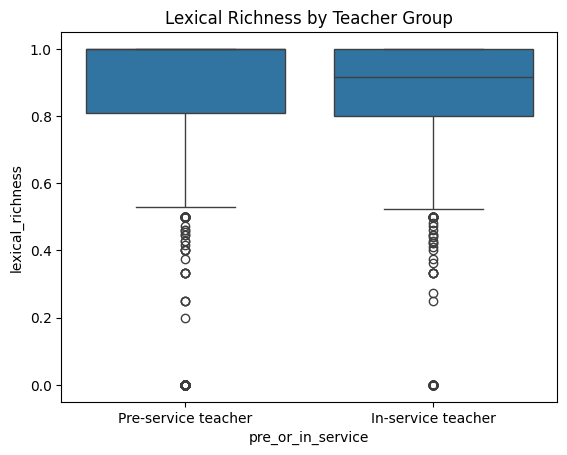

In [ ]:
def lexical_richness(text):
    tokens = text.split()
    unique_tokens = set(tokens)
    if len(tokens) == 0:
        return 0
    return len(unique_tokens) / len(tokens)

df['lexical_richness'] = df['clean_text_nostop'].apply(lexical_richness)

sns.boxplot(data=df, x='pre_or_in_service', y='lexical_richness')
plt.title('Lexical Richness by Teacher Group')
plt.show()


In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(language="multilingual")
topics, probs = topic_model.fit_transform(df['clean_text_nostop'])

# Add to df
df['topic'] = topics

# Compare topics by group
sns.countplot(data=df, x='topic', hue='pre_or_in_service')
plt.title('Topic Distribution by Group')
plt.show()


TypeError: MyLogger.__init__() takes 1 positional argument but 2 were given

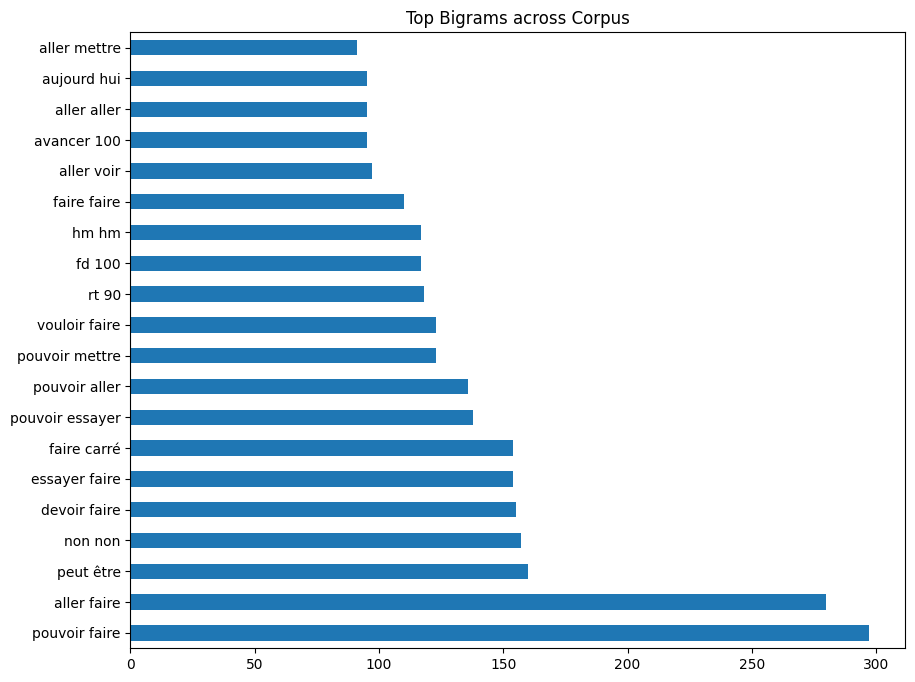

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2,2), min_df=5)
X = vectorizer.fit_transform(df['clean_text_nostop'])

# Convert into frequency table
bigrams = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
top_bigrams = bigrams.sum().sort_values(ascending=False).head(20)

top_bigrams.plot(kind='barh', figsize=(10,8))
plt.title('Top Bigrams across Corpus')
plt.show()


Counting subordinate clauses...


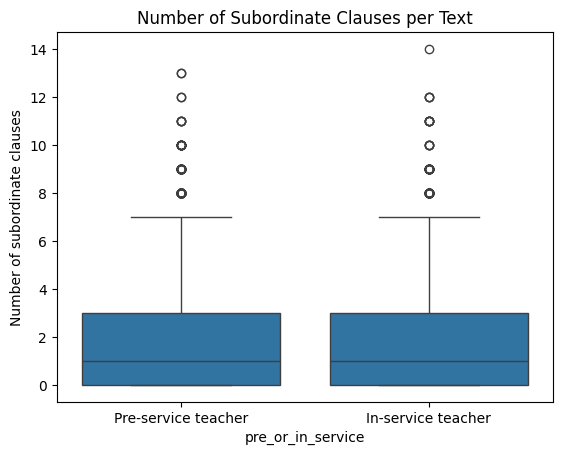

In [ ]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

nlp = spacy.load('fr_core_news_md')

def count_subordinate_clauses(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.dep_ in ['mark', 'advcl', 'ccomp', 'xcomp'])

print("Counting subordinate clauses...")

df['subordinate_clauses'] = df['clean text'].apply(count_subordinate_clauses)

# --- Plot Grammar Complexity ---
sns.boxplot(data=df, x='pre_or_in_service', y='subordinate_clauses')
plt.title('Number of Subordinate Clauses per Text')
plt.ylabel('Number of subordinate clauses')
plt.show()


Counting tenses and modality...


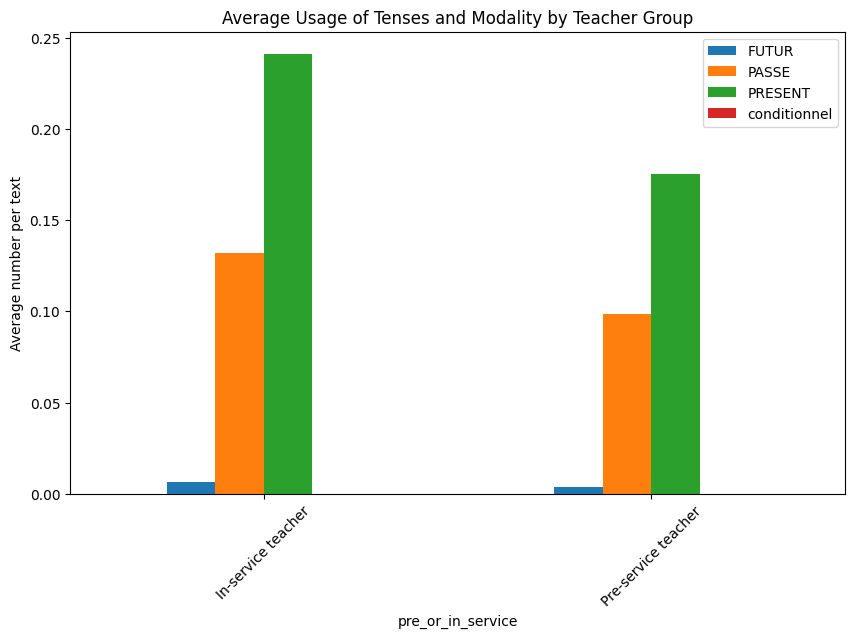

In [ ]:
def tense_and_modal_counts(text):
    doc = nlp(text)
    tenses = {"FUTUR": 0, "PASSE": 0, "PRESENT": 0}
    modals = {"conditionnel": 0}
    
    for token in doc:
        if token.tag_ == 'VERB':
            if 'Mood=Cond' in token.morph:  # Conditional
                modals['conditionnel'] += 1
            if 'Tense=Past' in token.morph:
                tenses['PASSE'] += 1
            if 'Tense=Fut' in token.morph:
                tenses['FUTUR'] += 1
            if 'Tense=Pres' in token.morph:
                tenses['PRESENT'] += 1
                
    return pd.Series({**tenses, **modals})

print("Counting tenses and modality...")
tense_modal_features = df['clean_text_nostop'].apply(tense_and_modal_counts)
df = pd.concat([df, tense_modal_features], axis=1)

# --- Plot tense usage ---

tense_summary = df.groupby('pre_or_in_service')[['FUTUR', 'PASSE', 'PRESENT', 'conditionnel']].mean()

tense_summary.plot(kind='bar', figsize=(10,6))
plt.title('Average Usage of Tenses and Modality by Teacher Group')
plt.ylabel('Average number per text')
plt.xticks(rotation=45)
plt.show()


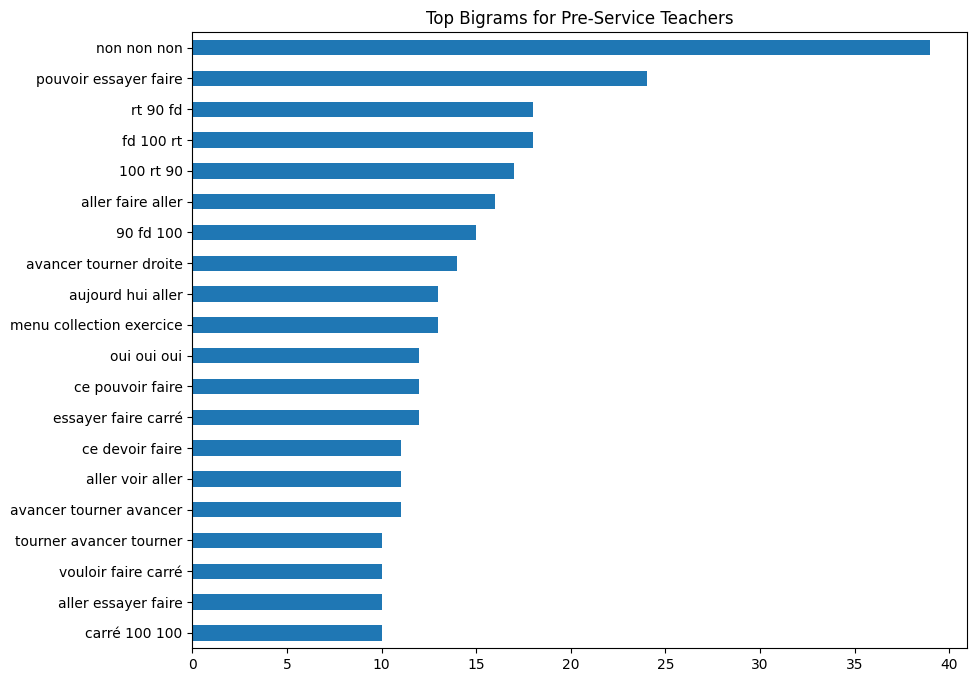

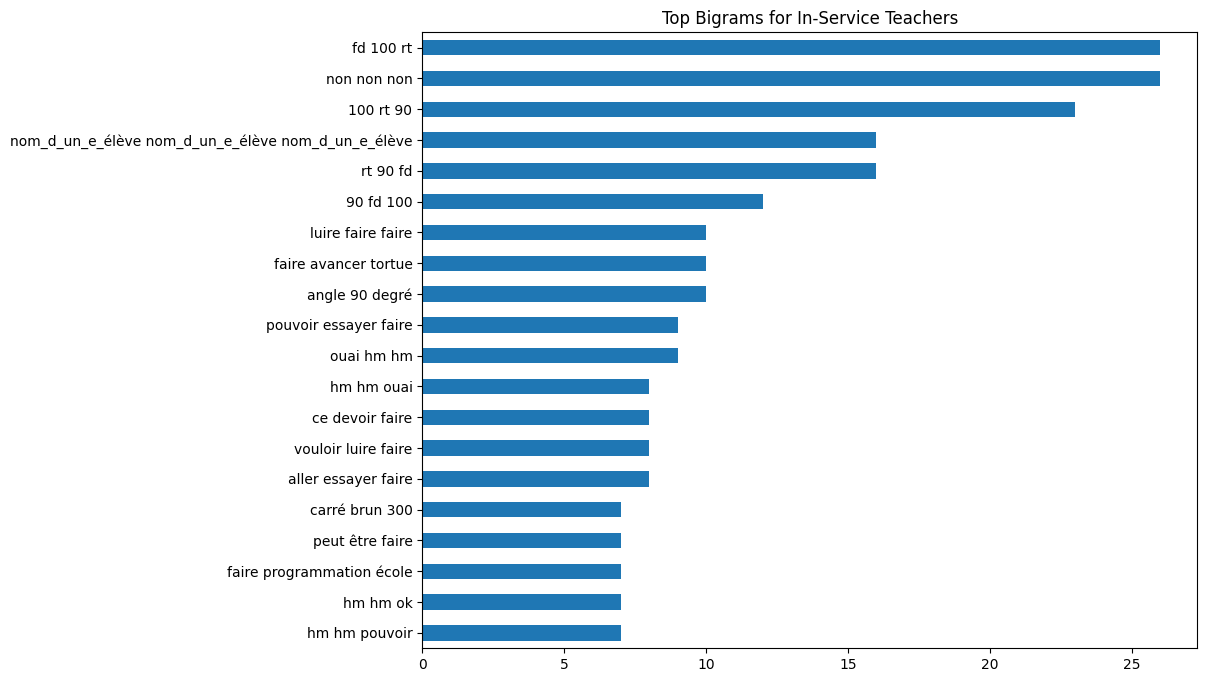

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Separate corpus
text_pre_service = df[df['pre_or_in_service'] == 'Pre-service teacher']['clean_text_nostop']
text_in_service = df[df['pre_or_in_service'] == 'In-service teacher']['clean_text_nostop']

# Bigram extractor
def plot_top_bigrams(texts, title):
    vectorizer = CountVectorizer(ngram_range=(3,3), min_df=5)
    X = vectorizer.fit_transform(texts)
    bigrams = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    top_bigrams = bigrams.sum().sort_values(ascending=False).head(20)
    
    top_bigrams.plot(kind='barh', figsize=(10,8))
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# --- Plot ---
plot_top_bigrams(text_pre_service, 'Top Treegrams for Pre-Service Teachers')
plot_top_bigrams(text_in_service, 'Top Treegrams for In-Service Teachers')


In [ ]:
# --- 0. Imports ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import numpy as np
from scipy.stats import ttest_ind

# --- 1. Preprocessing Enhancements ---

print("Applying improved text cleaning...")

# Drop short or empty texts
df = df[df['clean_text_nostop'].astype(str).str.split().apply(len) > 5]
df = df.dropna(subset=['clean_text_nostop'])

# Normalize texts (lowercase everything)
df['clean_text_nostop'] = df['clean_text_nostop'].str.lower()

# --- Fix Group Labels ---
print("Fixing group labels...")
df['pre_or_in_service'] = df['pre_or_in_service'].astype(str).str.strip().str.lower()

# Mapping known variations
mapping = {
    'in-service teacher': 'In-service',
    'pre-service teacher': 'Pre-service',
    'inservice': 'In-service',
    'preservice': 'Pre-service',
    'in-service': 'In-service',
    'pre-service': 'Pre-service'
}
df['pre_or_in_service'] = df['pre_or_in_service'].map(mapping)

# Drop rows with unmapped groups
df = df.dropna(subset=['pre_or_in_service'])

print(f"Corpus size after cleaning: {df.shape}")
print(f"Group distribution:\n{df['pre_or_in_service'].value_counts()}")

# --- 2. Speech Acts Detection (Inspired by Tong et al. 2024, Jensen et al. 2021) ---

print("Loading SpaCy model...")
nlp = spacy.load('fr_core_news_md')

def detect_speech_acts(text):
    """Detect number of questions, commands, and affirmations per text."""
    if not isinstance(text, str) or not text.strip():
        return pd.Series({'question': 0, 'command': 0, 'affirmation': 0})
    
    doc = nlp(text)
    sentences = list(doc.sents)
    counts = {'question': 0, 'command': 0, 'affirmation': 0}
    
    for sent in sentences:
        if sent.text.strip().endswith('?'):
            counts['question'] += 1
        elif any(token.tag_ == 'VERB' and 'Imp' in token.morph.get('Mood') for token in sent):
            counts['command'] += 1
        else:
            counts['affirmation'] += 1
    return pd.Series(counts)

print("Detecting speech acts...")
speech_acts = df['clean_text_nostop'].apply(detect_speech_acts)
df = pd.concat([df, speech_acts], axis=1)

# --- 3. Visualization ---

acts = ['question', 'command', 'affirmation']

# Means and stds
means = df.groupby('pre_or_in_service')[acts].mean()
stds = df.groupby('pre_or_in_service')[acts].std()

fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)

group_indices = np.arange(len(means.index))  # 0, 1 for In-service and Pre-service

for idx, act in enumerate(acts):
    axes[idx].bar(
        group_indices,
        means[act].values,
        yerr=stds[act].values,
        capsize=5
    )
    axes[idx].set_title(f"Average {act.capitalize()} per Group")
    axes[idx].set_ylabel("Average number per text")
    axes[idx].set_xticks(group_indices)
    axes[idx].set_xticklabels(means.index, rotation=45)
    axes[idx].grid(axis='y')

plt.tight_layout()
plt.show()

# --- 4. T-test: Number of Questions ---

print("\nStatistical Testing (T-test on Number of Questions):")
q_inservice = df[df['pre_or_in_service'] == 'In-service']['question'].dropna()
q_preservice = df[df['pre_or_in_service'] == 'Pre-service']['question'].dropna()

if len(q_inservice) > 1 and len(q_preservice) > 1:
    t_stat, p_val = ttest_ind(q_inservice, q_preservice, equal_var=False)
    print(f"T-test result: t = {t_stat:.3f}, p = {p_val:.4f}")
    if p_val < 0.05:
        print("✅ Significant difference in number of questions between groups!")
    else:
        print("❌ No statistically significant difference found.")
else:
    print("❌ Not enough samples to perform a valid t-test!")


Applying improved text cleaning...


KeyError: 'clean_text_nostop'

In [ ]:
# --- Define TPACK keyword dictionaries (you can expand them) ---

pedagogical_keywords = [
    "gestion", "différenciation", "pédagogie", "motivation", "organisation", 
    "apprentissage", "enseignement", "évaluation", "classe", "objectifs"
]

content_keywords = [
    "variable", "boucle", "condition", "fonction", "algorithme", 
    "programme", "code", "instruction", "répéter", "ordinateur"
]

technology_keywords = [
    "tablette", "application", "logiciel", "ordinateur", "internet", 
    "plateforme", "technologie", "réseau", "numérique", "robot"
]


In [ ]:
def count_tpack(text):
    words = text.lower().split()
    pedag = sum(1 for w in words if w in pedagogical_keywords)
    content = sum(1 for w in words if w in content_keywords)
    tech = sum(1 for w in words if w in technology_keywords)
    return pd.Series({
        'pedagogical_count': pedag,
        'content_count': content,
        'technology_count': tech
    })

print("Counting TPACK mentions...")
tpack_counts = df['clean_text_nostop'].apply(count_tpack)
df = pd.concat([df, tpack_counts], axis=1)


Counting TPACK mentions...


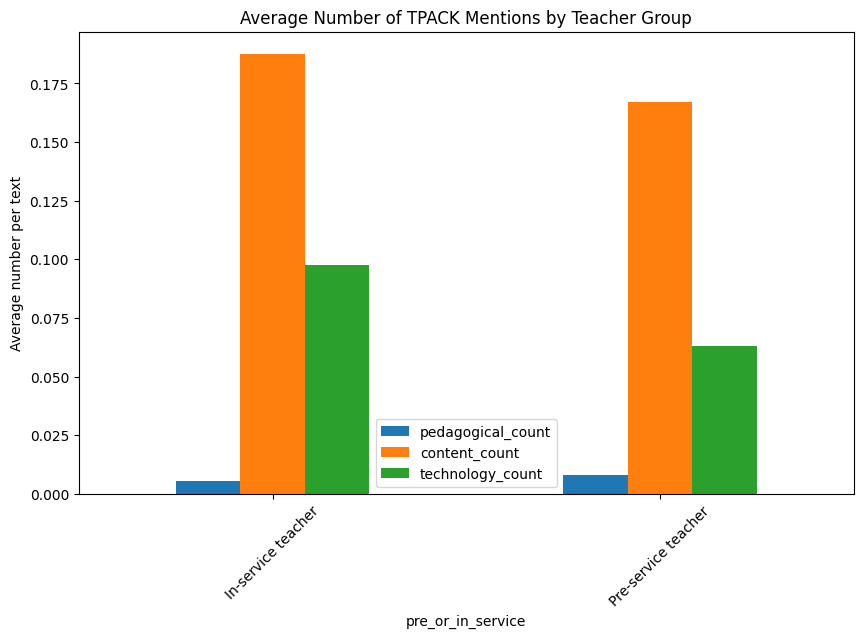

In [ ]:
# --- Group and visualize ---

tpack_summary = df.groupby('pre_or_in_service')[['pedagogical_count', 'content_count', 'technology_count']].mean()

tpack_summary.plot(kind='bar', figsize=(10,6))
plt.title('Average Number of TPACK Mentions by Teacher Group')
plt.ylabel('Average number per text')
plt.xticks(rotation=45)
plt.show()
